In [1]:
from typing import Any, Dict, List, Union, Literal

import numpy as np
import sapien
import torch

from mani_skill import ASSET_DIR
from mani_skill.agents.robots.fetch.fetch import Fetch
from mani_skill.agents.robots.panda.panda import Panda
from mani_skill.agents.robots.panda.panda_wristcam import PandaWristCam
from mani_skill.agents.robots.xmate3.xmate3 import Xmate3Robotiq
from mani_skill.envs.sapien_env import BaseEnv
from mani_skill.envs.utils.randomization.pose import random_quaternions
from mani_skill.sensors.camera import CameraConfig
from mani_skill.utils import common, sapien_utils
from mani_skill.utils.building import actors
from mani_skill.utils.io_utils import load_json
from mani_skill.utils.registration import register_env
from mani_skill.utils.scene_builder.table import TableSceneBuilder
from mani_skill.utils.structs.actor import Actor
from mani_skill.utils.structs.pose import Pose
from mani_skill.utils.structs.types import GPUMemoryConfig, SimConfig

import gymnasium as gym
import mani_skill.envs
import torch
import time

In [2]:
WARNED_ONCE = False


@register_env("MyPushCube-v1", max_episode_steps=50, asset_download_ids=["ycb"])
class MyPushCube(BaseEnv):

    SUPPORTED_ROBOTS = ["panda", "panda_wristcam", "fetch"]
    agent: Union[Panda, PandaWristCam, Fetch]
    goal_thresh = 0.025

    def __init__(
        self,
        *args,
        robot_uids="panda_wristcam",
        robot_init_qpos_noise=0.02,
        num_envs=1,
        reconfiguration_freq=None,
        **kwargs,
    ):
        self.robot_init_qpos_noise = robot_init_qpos_noise
        self.model_id = None
        self.all_model_ids = np.array(
            list(
                load_json(ASSET_DIR / "assets/mani_skill2_ycb/info_pick_v0.json").keys()
            )
        )
        if reconfiguration_freq is None:
            if num_envs == 1:
                reconfiguration_freq = 1
            else:
                reconfiguration_freq = 0
        super().__init__(
            *args,
            robot_uids=robot_uids,
            reconfiguration_freq=reconfiguration_freq,
            num_envs=num_envs,
            **kwargs,
        )

    @property
    def _default_sensor_configs(self):
        pose = sapien_utils.look_at(eye=[0.3, 0, 0.6], target=[-0.1, 0, 0.1])
        return [CameraConfig("base_camera", pose, 128, 128, np.pi / 2, 0.01, 100)]

    @property
    def _default_human_render_camera_configs(self):
        pose = sapien_utils.look_at([0.6, 0.7, 0.6], [0.0, 0.0, 0.35])
        return CameraConfig("render_camera", pose, 512, 512, 1, 0.01, 100)

    def _load_agent(self, options: dict):
        super()._load_agent(options, sapien.Pose(p=[-0.615, 0, 0]))

    def _load_scene(self, options: dict):
        global WARNED_ONCE
        self.table_scene = TableSceneBuilder(
            env=self, robot_init_qpos_noise=self.robot_init_qpos_noise
        )
        self.table_scene.build()

        # randomize the list of all possible models in the YCB dataset
        # then sub-scene i will load model model_ids[i % number_of_ycb_objects]
        model_ids = self._batched_episode_rng.choice(self.all_model_ids, replace=True)
        if (
            self.num_envs > 1
            and self.num_envs < len(self.all_model_ids)
            and self.reconfiguration_freq <= 0
            and not WARNED_ONCE
        ):
            WARNED_ONCE = True
            print(
                """There are less parallel environments than total available models to sample.
                Not all models will be used during interaction even after resets unless you call env.reset(options=dict(reconfigure=True))
                or set reconfiguration_freq to be >= 1."""
            )

        # ! MUG-1 INITIALIZATION
        self._objs_1: List[Actor] = []
        self.obj_heights = []
        for i, model_id in enumerate(model_ids):
            model_id = "065-f_cups"
            # print(i, model_id)
            # TODO: before official release we will finalize a metadata dataclass that these build functions should return.
            builder = actors.get_actor_builder(
                self.scene,
                id=f"ycb:{model_id}",
            )
            builder.initial_pose = sapien.Pose(p=[0, 0, 0])
            builder.set_scene_idxs([i])
            self._objs_1.append(builder.build(name=f"{model_id}-1-{i}"))
            self.remove_from_state_dict_registry(self._objs_1[-1])
        self.mug_1 = Actor.merge(self._objs_1, name="mug_1")
        self.add_to_state_dict_registry(self.mug_1)

        # ! MUG-2 INITIALIZATION
        self._objs_2: List[Actor] = []
        self.obj_heights = []
        for i, model_id in enumerate(model_ids):
            model_id = "065-f_cups"
            # print(i, model_id)
            # TODO: before official release we will finalize a metadata dataclass that these build functions should return.
            builder = actors.get_actor_builder(
                self.scene,
                id=f"ycb:{model_id}",
            )
            builder.initial_pose = sapien.Pose(p=[0, 0, 0])
            builder.set_scene_idxs([i])
            self._objs_2.append(builder.build(name=f"{model_id}-2-{i}"))
            self.remove_from_state_dict_registry(self._objs_2[-1])
        self.mug_2 = Actor.merge(self._objs_2, name="mug_2")
        self.add_to_state_dict_registry(self.mug_2)

        # ! MUG-1 INITIALIZATION
        self._objs_3: List[Actor] = []
        self.obj_heights = []
        for i, model_id in enumerate(model_ids):
            model_id = "065-f_cups"
            # print(i, model_id)
            # TODO: before official release we will finalize a metadata dataclass that these build functions should return.
            builder = actors.get_actor_builder(
                self.scene,
                id=f"ycb:{model_id}",
            )
            builder.initial_pose = sapien.Pose(p=[0, 0, 0])
            builder.set_scene_idxs([i])
            self._objs_3.append(builder.build(name=f"{model_id}-3-{i}"))
            self.remove_from_state_dict_registry(self._objs_3[-1])
        self.mug_3 = Actor.merge(self._objs_3, name="mug_3")
        self.add_to_state_dict_registry(self.mug_3)

        self.goal_site = actors.build_sphere(
            self.scene,
            radius=self.goal_thresh,
            color=[0, 1, 0, 1],
            name="goal_site",
            body_type="kinematic",
            add_collision=False,
            initial_pose=sapien.Pose(),
        )
        self._hidden_objects.append(self.goal_site)


        # !!!!!!!!!!!!! BALL
        # Define color options
        self.color_options = [
            np.array([255, 0, 0, 255]) / 255,  # Red
            np.array([0, 255, 0, 255]) / 255,  # Green
            np.array([0, 0, 255, 255]) / 255,  # Blue
        ]
        
        # Create the main ball that will change color
        self.ball = actors.build_sphere(
            self.scene,
            radius=0.02,#self.cube_half_size,
            color=self.color_options[0],  # Initial color (will be updated in _initialize_episode)
            name="color_ball",
            body_type="dynamic",
            initial_pose=sapien.Pose(p=[0, 0, 0.02]),#self.cube_half_size]),
        )
        # !!!!!!!!!!!!! BALL

    def _after_reconfigure(self, options: dict):
        self.object_zs = []
        for i, obj_group in enumerate([self._objs_1, self._objs_2, self._objs_3]):
            for obj in obj_group:
                collision_mesh = obj.get_first_collision_mesh()
                self.object_zs.append(-collision_mesh.bounding_box.bounds[0, 2])
        self.object_zs = common.to_tensor(self.object_zs, device=self.device)


    def _initialize_episode(self, env_idx: torch.Tensor, options: dict):
        with torch.device(self.device):

            self.current_color = self._batched_episode_rng.choice([0, 1, 2])
            self.current_color = torch.from_numpy(self.current_color).to(self.device)


            b = len(env_idx)
            self.table_scene.initialize(env_idx)

            # ! MUG-1
            xyz = torch.zeros((b, 3))
            xyz[:, :2] = torch.rand((b, 2)) * 0.2 - 0.1
            xyz[:, 2] = self.object_zs[env_idx]
            q = torch.tensor([0, 1, 0, 0]).repeat(b, 1)

            min_dist = 0.2
            self.mug_1.set_pose(Pose.create_from_pq(p=xyz, q=q))
            self.mug_2.set_pose(Pose.create_from_pq(p=xyz + torch.tensor([0, min_dist, 0]).repeat(b, 1), q=q))
            self.mug_3.set_pose(Pose.create_from_pq(p=xyz + torch.tensor([0, -min_dist, 0]).repeat(b, 1), q=q))


            # !!!!!!!!!!!!! BALL
            # Set ball position and color
            ball_xyz = torch.zeros((b, 3))
            ball_xyz[..., :2] = torch.rand((b, 2)) * 0.2 - 0.1
            ball_xyz[..., 2] = 0.02#self.cube_half_size
            ball_pose = Pose.create_from_pq(p=ball_xyz, q=q)
            self.ball.set_pose(ball_pose)
            
            # Update ball color based on current_color
            # self.ball.visual_body.set_color(self.color_options[self.current_color.item()])
            # !!!!!!!!!!!!! BALL

            goal_xyz = torch.zeros((b, 3))
            goal_xyz[:, :2] = torch.rand((b, 2)) * 0.2 - 0.1
            goal_xyz[:, 2] = torch.rand((b)) * 0.3 + xyz[:, 2]
            self.goal_site.set_pose(Pose.create_from_pq(goal_xyz))

            # Initialize robot arm to a higher position above the table than the default typically used for other table top tasks
            if self.robot_uids == "panda" or self.robot_uids == "panda_wristcam":
                # fmt: off
                qpos = np.array(
                    [0.0, 0, 0, -np.pi * 2 / 3, 0, np.pi * 2 / 3, np.pi / 4, 0.04, 0.04]
                )
                # fmt: on
                qpos[:-2] += self._episode_rng.normal(
                    0, self.robot_init_qpos_noise, len(qpos) - 2
                )
                self.agent.reset(qpos)
                self.agent.robot.set_root_pose(sapien.Pose([-0.615, 0, 0]))
            elif self.robot_uids == "xmate3_robotiq":
                qpos = np.array([0, 0.6, 0, 1.3, 0, 1.3, -1.57, 0, 0])
                qpos[:-2] += self._episode_rng.normal(
                    0, self.robot_init_qpos_noise, len(qpos) - 2
                )
                self.agent.reset(qpos)
                self.agent.robot.set_root_pose(sapien.Pose([-0.562, 0, 0]))
            else:
                raise NotImplementedError(self.robot_uids)

    def evaluate(self):
        obj_to_goal_pos = self.goal_site.pose.p - self.mug_1.pose.p
        is_obj_placed = torch.linalg.norm(obj_to_goal_pos, axis=1) <= self.goal_thresh
        is_grasped = self.agent.is_grasping(self.mug_1)
        is_robot_static = self.agent.is_static(0.2)
        return dict(
            is_grasped=is_grasped,
            obj_to_goal_pos=obj_to_goal_pos,
            is_obj_placed=is_obj_placed,
            is_robot_static=is_robot_static,
            is_grasping=self.agent.is_grasping(self.mug_1),
            success=torch.logical_and(is_obj_placed, is_robot_static),
        )

    def _get_obs_extra(self, info: Dict):
        obs = dict(
            tcp_pose=self.agent.tcp.pose.raw_pose,
            goal_pos=self.goal_site.pose.p,
            is_grasped=info["is_grasped"],
            color=self.current_color,
        )
        if "state" in self.obs_mode:
            obs.update(
                tcp_to_goal_pos=self.goal_site.pose.p - self.agent.tcp.pose.p,
                obj_pose=self.mug_1.pose.raw_pose,
                tcp_to_obj_pos=self.mug_1.pose.p - self.agent.tcp.pose.p,
                obj_to_goal_pos=self.goal_site.pose.p - self.mug_1.pose.p,
            )
        return obs

    def compute_dense_reward(self, obs: Any, action: torch.Tensor, info: Dict):
        tcp_to_obj_dist = torch.linalg.norm(
            self.mug_1.pose.p - self.agent.tcp.pose.p, axis=1
        )
        reaching_reward = 1 - torch.tanh(5 * tcp_to_obj_dist)
        reward = reaching_reward

        is_grasped = info["is_grasped"]
        reward += is_grasped

        obj_to_goal_dist = torch.linalg.norm(
            self.goal_site.pose.p - self.mug_1.pose.p, axis=1
        )
        place_reward = 1 - torch.tanh(5 * obj_to_goal_dist)
        reward += place_reward * is_grasped

        reward += info["is_obj_placed"] * is_grasped

        static_reward = 1 - torch.tanh(
            5 * torch.linalg.norm(self.agent.robot.get_qvel()[..., :-2], axis=1)
        )
        reward += static_reward * info["is_obj_placed"] * is_grasped

        reward[info["success"]] = 6
        return reward

    def compute_normalized_dense_reward(
        self, obs: Any, action: torch.Tensor, info: Dict
    ):
        return self.compute_dense_reward(obs=obs, action=action, info=info) / 6
    


class ColorObservationWrapper(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)

        init_obs = self.observation(self.base_env._init_raw_obs)
        self.base_env.update_obs_space(init_obs)
    
    @property
    def base_env(self) -> BaseEnv:
        return self.env.unwrapped

    
    def observation(self, obs):
        # print(self.base_env.num_envs)
        color = self.base_env._batched_episode_rng.choice([0, 1, 2])#, size=(self.base_env.num_envs,))
        color = torch.from_numpy(color).to(self.base_env.device)
        
        if isinstance(obs, dict):
            obs = obs.copy()
            obs['color'] = color
        return obs

In [3]:
num_envs = 2 # you can go up higher on better GPUs, this is mostly memory constrained
env = gym.make("MyPushCube-v1", num_envs=num_envs, obs_mode="rgb")#, render_mode="rgb_array")
env = ColorObservationWrapper(env)
# env = MyPushCubeEnv(num_envs=num_envs, obs_mode="rgb")
# env.unwrapped.print_sim_details()
SEED = 42
obs, _ = env.reset(seed=SEED)
print(obs['color'])
done = False
start_time = time.time()
total_rew = 0
while not done:
    # note that env.action_space is now a batched action space
    obs, rew, terminated, truncated, info = env.step(torch.from_numpy(env.action_space.sample()))
    done = (terminated | truncated).any() # stop if any environment terminates/truncates
N = num_envs * info["elapsed_steps"][0].item()
dt = time.time() - start_time
FPS = N / (dt)
print(f"Frames Per Second = {N} / {dt} = {FPS}")

There are less parallel environments than total available models to sample.
                Not all models will be used during interaction even after resets unless you call env.reset(options=dict(reconfigure=True))
                or set reconfiguration_freq to be >= 1.
tensor([1, 2], device='cuda:0')
Frames Per Second = 100 / 5.1323018074035645 = 19.484434811636707


dict_keys(['agent', 'extra', 'sensor_param', 'sensor_data', 'color'])
dict_keys(['base_camera', 'hand_camera'])
dict_keys(['rgb'])
torch.Size([2, 128, 128, 3])


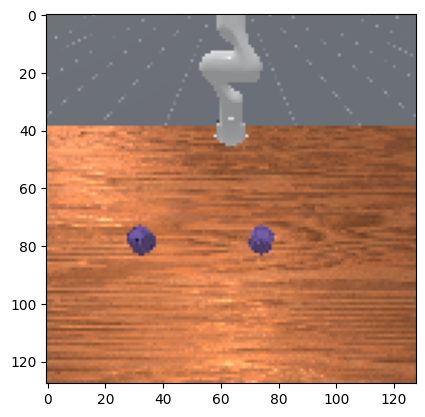

In [4]:
# visualize the image data from the environment and inspect the data
print(obs.keys())
print(obs['sensor_data'].keys())
print(obs['sensor_data']['base_camera'].keys())
print(obs['sensor_data']['base_camera']['rgb'].shape)
import matplotlib.pyplot as plt

plt.imshow(obs['sensor_data']['base_camera']['rgb'][0].cpu().numpy())
plt.show()

In [5]:
# Import required packages
import gymnasium as gym
import torch
import mani_skill.envs
from tqdm.notebook import tqdm
from mani_skill.utils.wrappers import RecordEpisode
# render_mode="sensors" for real observations (rgb+d) or "rgb_array" for external camera
env = gym.make("MyPushCube-v1", num_envs=num_envs, obs_mode="rgb", render_mode="rgb_array")
env = RecordEpisode(
    env,
    "./videos", # the directory to save replay videos and trajectories to
    # on GPU sim we record intervals, not by single episodes as there are multiple envs
    # each 100 steps a new video is saved
    max_steps_per_video=100
)

# step through the environment with random actions
obs, _ = env.reset()
for i in tqdm(range(100)):
    action = env.action_space.sample()
    obs, reward, terminated, truncated, info = env.step(torch.from_numpy(action))
    # env.render_human() # will render with a window if possible
env.close()
from IPython.display import Video
Video("./videos/0.mp4", embed=True, width=640) # Watch our replay

2024-11-08 22:30:51,033 - mani_skill  - WARNING - mani_skill is not installed with git.


  0%|          | 0/100 [00:00<?, ?it/s]